In [1]:
import torch
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
sys.path.append(os.path.abspath(os.path.join(os.path.dirname('examples'), '..')))

from tedeous.data import Domain, Conditions, Equation
from tedeous.model import Model
from tedeous.models import mat_model, Fourier_embedding
from tedeous.callbacks import plot, early_stopping, adaptive_lambda
from tedeous.optimizers.optimizer import Optimizer
from tedeous.device import solver_device

In [ ]:
solver_device('cuda')

def u(x):
    return torch.tanh(x)

def u_x(x):
   return (1./ torch.cosh(x))**2

def u_xx(x):
    return -2*(1./ torch.cosh(x))**2*torch.tanh(x)

def u_net(net, x):
    net = net.to('cpu')
    x = x.to('cpu')
    return net(x).detach()

def u_net_x(net, x):
    x = x.to('cpu')
    net = net.to('cpu')
    x.requires_grad_()
    u = net(x)
    u_x = torch.autograd.grad(sum(u), x)[0]
    return u_x.detach()

def u_net_xx(net, x):
    x = x.to('cpu')
    net = net.to('cpu')
    x.requires_grad_()
    u = net(x)
    u_x = torch.autograd.grad(sum(u), x, create_graph=True)[0]
    u_xx = torch.autograd.grad(sum(u_x), x)[0]
    return u_xx.detach()

def c2_norm(net, x):
    norms = [(u, u_net), (u_x, u_net_x), (u_xx, u_net_xx)]
    norm = 0
    for exact, predict in norms:
        norm += torch.max(abs(exact(x).cpu().reshape(-1) - predict(net, x).cpu().reshape(-1)))
    return norm.detach().cpu().numpy()

def l2_norm(net, x):
    x = x.to('cpu')
    net = net.to('cpu')
    predict = net(x).detach().cpu().reshape(-1)
    exact = u(x).detach().cpu().reshape(-1)
    l2_norm = torch.sqrt(sum((predict-exact)**2))
    return l2_norm.detach().cpu().numpy()

def l2_norm_mat(net, x):
    x = x.to('cpu')
    net = net.to('cpu')
    predict = net.detach().cpu().reshape(-1)
    exact = u(x).detach().cpu().reshape(-1)
    l2_norm = torch.sqrt(sum((predict-exact)**2))
    return l2_norm.detach().cpu().numpy()


def experiment(N):
    exp_dict_list = []

    x0 = -1
    xmax = 1

    domain = Domain()

    domain.variable('x', [x0, xmax], N, dtype='float32')

    boundaries = Conditions()

    boundaries.dirichlet({'x': x0}, value=u)
    boundaries.dirichlet({'x': xmax}, value=u)

    grid = domain.variable_dict['x'].reshape(-1,1)

    # equation: d2u/dx2 = -16*pi^2*sin(4*pi*x)

    equation = Equation()

    poisson = {
        '-d2u/dx2':
            {
            'coeff': -1,
            'term': [0, 0],
            'pow': 1,
            },

        'f(x)':
            {
            'coeff': u_xx(grid),
            'term': [None],
            'pow': 0,
            }
    }

    equation.add(poisson)

    net = torch.nn.Sequential(
            torch.nn.Linear(1, 50),
            torch.nn.Tanh(),
            torch.nn.Linear(50, 50),
            torch.nn.Tanh(),
            torch.nn.Linear(50, 50),
            torch.nn.Tanh(),
            torch.nn.Linear(50, 1)
        )

    model = Model(net, domain, equation, boundaries)

    model.compile('autograd', lambda_operator=1, lambda_bound=1)
    
    cb_es = early_stopping.EarlyStopping(eps=1e-9, randomize_parameter=1e-6)

    optimizer = Optimizer('Adam', {'lr': 1e-4}, gamma=0.9, decay_every=1000)

    model.train(optimizer, 5e5, save_model=False, callbacks=[cb_es])

    l2_loss = model.solution_cls.evaluate()[0].detach().cpu().numpy()

    l2_op_loss = torch.mean(model.solution_cls.operator.operator_compute()**2)

    grid_error = torch.linspace(-1, 1, 10001).reshape(-1,1)

    T_norm = torch.max(model.solution_cls.operator.operator_compute() / model.net(grid))**2

    upper_bound_error = 2 * (l2_op_loss-1e-8) + T_norm

    exp_dict_list.append({'grid_res': N, 'l2_loss': l2_loss, "l2_op_loss": l2_op_loss, 'l2_norm': l2_norm(net, grid_error), 'error_bound': upper_bound_error.item(), 'type':'Poisson'})

    print('grid_res=', N)
    print('l2_op_loss = ', l2_op_loss.item())
    print('l2_norm = ', l2_norm(net, grid_error)**2)

    plt.plot(grid.detach().cpu().numpy(), u(grid).detach().cpu().numpy(), label='Exact')
    plt.plot(grid.detach().cpu().numpy(), net(grid.cpu()).detach().cpu().numpy(), '--', label='Predicted')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(loc='upper right')
    plt.show()

    return exp_dict_list

def experiment_PSO(N):
    exp_dict_list = []

    x0 = -1
    xmax = 1

    domain = Domain()

    domain.variable('x', [x0, xmax], N, dtype='float32')

    boundaries = Conditions()

    boundaries.dirichlet({'x': x0}, value=u)
    boundaries.dirichlet({'x': xmax}, value=u)

    grid = domain.variable_dict['x']
    # equation: d2u/dx2 = -16*pi^2*sin(4*pi*x)

    equation = Equation()

    poisson = {
        '-d2u/dx2':
            {
            'coeff': -1,
            'term': [0, 0],
            'pow': 1,
            },

        'f(x)':
            {
            'coeff': u_xx(grid),
            'term': [None],
            'pow': 0,
            }
    }

    equation.add(poisson)

    net = torch.nn.Sequential(
            torch.nn.Linear(1, 50),
            torch.nn.Tanh(),
            torch.nn.Linear(50, 50),
            torch.nn.Tanh(),
            torch.nn.Linear(50, 50),
            torch.nn.Tanh(),
            torch.nn.Linear(50, 1)
        )

    model = Model(net, domain, equation, boundaries)

    model.compile('autograd', lambda_operator=1, lambda_bound=1)

    cb_es = early_stopping.EarlyStopping(eps=1e-9, randomize_parameter=1e-6)

    optimizer = Optimizer('Adam', {'lr': 1e-4}, gamma=0.9, decay_every=1000)

    model.train(optimizer, 5e5, save_model=False, callbacks=[cb_es])

    grid_error = torch.linspace(-1, 1, 10001).reshape(-1,1)

    l2_pinn = l2_norm(net, grid_error)
    print('l2_norm = ', l2_pinn)
    net = net.to('cuda')

    ########

    cb_es = early_stopping.EarlyStopping(eps=1e-9, randomize_parameter=1e-6, info_string_every=1000)

    optimizer = Optimizer('PSO', {'pop_size': 50, #30
                                  'b': 0.4, #0.5
                                  'c2': 0.5, #0.05
                                  'c1': 0.5, 
                                  'variance': 5e-2,
                                  'lr': 1e-4})

    model.train(optimizer, 20000, save_model=False, callbacks=[cb_es])


    l2_loss = model.solution_cls.evaluate()[0].detach().cpu().numpy()

    grid_error = torch.linspace(-1, 1, 10001).reshape(-1,1)

    exp_dict_list.append({'grid_res': N, 'l2_loss': l2_loss, 'l2_PSO': l2_norm(net, grid_error), 'l2_pinn': l2_pinn, 'c2_norm': c2_norm(net, grid_error), 'type':'Poisson_PSO'})

    print('grid_res=', N)
    print('c2_norm = ', c2_norm(net, grid_error))
    print('l2_norm = ', l2_norm(net, grid_error))

    plt.plot(grid.detach().cpu().numpy(), u(grid).detach().cpu().numpy(), label='Exact')
    plt.plot(grid.detach().cpu().numpy(), net(grid.reshape(-1,1).cpu()).detach().cpu().numpy(), '--', label='Predicted')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(loc='upper right')
    plt.show()

    return exp_dict_list

def experiment_mat(N):
    solver_device('cuda')

    exp_dict_list = []

    x0 = -1
    xmax = 1

    domain = Domain()

    domain.variable('x', [x0, xmax], N, dtype='float32')

    boundaries = Conditions()

    boundaries.dirichlet({'x': x0}, value=u)
    boundaries.dirichlet({'x': xmax}, value=u)

    grid = domain.variable_dict['x']
    # equation: d2u/dx2 = -16*pi^2*sin(4*pi*x)

    equation = Equation()

    poisson = {
        '-d2u/dx2':
            {
            'coeff': -1,
            'term': [0, 0],
            'pow': 1,
            },

        'f(x)':
            {
            'coeff': u_xx(grid),
            'term': [None],
            'pow': 0,
            }
    }

    equation.add(poisson)

    net = torch.nn.Sequential(
            torch.nn.Linear(1, 50),
            torch.nn.Tanh(),
            torch.nn.Linear(50, 50),
            torch.nn.Tanh(),
            torch.nn.Linear(50, 50),
            torch.nn.Tanh(),
            torch.nn.Linear(50, 1)
        )

    model = Model(net, domain, equation, boundaries)

    model.compile('autograd', lambda_operator=1, lambda_bound=1)

    cb_es = early_stopping.EarlyStopping(eps=1e-9, randomize_parameter=1e-6)

    optimizer = Optimizer('Adam', {'lr': 1e-4})

    model.train(optimizer, 5e5, save_model=False, callbacks=[cb_es])

    grid = torch.linspace(-1, 1, N+1).reshape(-1,1)

    l2_pinn = l2_norm(net, grid)
    print('l2_norm = ', l2_pinn)
    net = net.to('cuda')


    ########
    solver_device('cpu')

    net = net(grid).reshape(1, N+1).detach().cpu()

    domain = Domain()

    domain.variable('x', [x0, xmax], N, dtype='float32')

    boundaries = Conditions()

    boundaries.dirichlet({'x': x0}, value=u)
    boundaries.dirichlet({'x': xmax}, value=u)

    grid = domain.variable_dict['x']
    # equation: d2u/dx2 = -16*pi^2*sin(4*pi*x)

    equation = Equation()

    poisson = {
        '-d2u/dx2':
            {
            'coeff': -1,
            'term': [0, 0],
            'pow': 1,
            },

        'f(x)':
            {
            'coeff': u_xx(grid),
            'term': [None],
            'pow': 0,
            }
    }

    equation.add(poisson)

    model = Model(net, domain, equation, boundaries)

    model.compile('mat', lambda_operator=1, lambda_bound=1, derivative_points=3)

    cb_es = early_stopping.EarlyStopping(eps=1e-9, randomize_parameter=1e-6)

    optimizer = Optimizer('LBFGS', {'lr': 1e-2})

    model.train(optimizer, 5e5, save_model=False, callbacks=[cb_es])

    l2_loss = model.solution_cls.evaluate()[0].detach().cpu().numpy()

    grid = domain.build('mat')

    exp_dict_list.append({'grid_res': N, 'l2_loss': l2_loss, 'l2_mat': l2_norm_mat(net, grid), 'l2_pinn': l2_pinn, 'type':'Poisson_mat'})

    print('grid_res=', N)
    print('l2_norm = ', l2_norm_mat(net, grid))

    plt.plot(grid.detach().cpu().numpy().reshape(-1), u(grid).detach().cpu().numpy().reshape(-1), label='Exact')
    plt.plot(grid.detach().cpu().numpy().reshape(-1), net.detach().cpu().numpy().reshape(-1), '--', label='Predicted')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(loc='upper right')
    plt.show()

    return exp_dict_list

def experiment_neur(N):
    exp_dict_list = []

    x0 = -1
    xmax = 1

    domain = Domain()

    domain.variable('x', [x0, xmax], 300, dtype='float32')

    boundaries = Conditions()

    boundaries.dirichlet({'x': x0}, value=u)
    boundaries.dirichlet({'x': xmax}, value=u)

    grid = domain.variable_dict['x'].reshape(-1,1)

    # equation: d2u/dx2 = -16*pi^2*sin(4*pi*x)

    equation = Equation()

    poisson = {
        '-d2u/dx2':
            {
            'coeff': -1,
            'term': [0, 0],
            'pow': 1,
            },

        'f(x)':
            {
            'coeff': u_xx(grid),
            'term': [None],
            'pow': 0,
            }
    }

    equation.add(poisson)

    net = torch.nn.Sequential(
            torch.nn.Linear(1, N),
            torch.nn.Tanh(),
            torch.nn.Linear(N, N),
            torch.nn.Tanh(),
            torch.nn.Linear(N, N),
            torch.nn.Tanh(),
            torch.nn.Linear(N, 1)
        )

    model = Model(net, domain, equation, boundaries)

    model.compile('autograd', lambda_operator=1, lambda_bound=1)

    img_dir = os.path.join(os.path.dirname('examples'), 'poisson_img')
    
    cb_es = early_stopping.EarlyStopping(eps=1e-9, randomize_parameter=1e-6)

    cb_plots = plot.Plots(save_every=None, print_every=None, img_dir=img_dir)

    optimizer = Optimizer('Adam', {'lr': 1e-4}, gamma=0.9, decay_every=1000)

    model.train(optimizer, 5e5, save_model=False, callbacks=[cb_plots, cb_es])

    l2_loss = model.solution_cls.evaluate()[0].detach().cpu().numpy()

    grid_error = torch.linspace(-1, 1, 10001).reshape(-1,1)

    exp_dict_list.append({'NN_res': N, 'l2_loss': l2_loss, 'l2_norm': l2_norm(net, grid_error), 'c2_norm': c2_norm(net, grid_error), 'type':'Poisson'})

    print('grid_res=', N)
    print('c2_norm = ', c2_norm(net, grid_error))
    print('l2_norm = ', l2_norm(net, grid_error))

    plt.plot(grid.detach().cpu().numpy(), u(grid).detach().cpu().numpy(), label='Exact')
    plt.plot(grid.detach().cpu().numpy(), net(grid.cpu()).detach().cpu().numpy(), '--', label='Predicted')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(loc='upper right')
    plt.show()

    return exp_dict_list

def experiment_lam(N):
    exp_dict_list = []

    x0 = -1
    xmax = 1

    domain = Domain()

    domain.variable('x', [x0, xmax], N, dtype='float32')

    boundaries = Conditions()

    boundaries.dirichlet({'x': x0}, value=u)
    boundaries.dirichlet({'x': xmax}, value=u)

    grid = domain.variable_dict['x'].reshape(-1,1)

    # equation: d2u/dx2 = -16*pi^2*sin(4*pi*x)

    equation = Equation()

    poisson = {
        '-d2u/dx2':
            {
            'coeff': -1,
            'term': [0, 0],
            'pow': 1,
            },

        'f(x)':
            {
            'coeff': u_xx(grid),
            'term': [None],
            'pow': 0,
            }
    }

    equation.add(poisson)

    net = torch.nn.Sequential(
            torch.nn.Linear(1, 50),
            torch.nn.Tanh(),
            torch.nn.Linear(50, 50),
            torch.nn.Tanh(),
            torch.nn.Linear(50, 50),
            torch.nn.Tanh(),
            torch.nn.Linear(50, 1)
        )

    model = Model(net, domain, equation, boundaries)

    model.compile('autograd', lambda_operator=1, lambda_bound=1)

    img_dir = os.path.join(os.path.dirname('examples'), 'poisson_img')

    cb_lam = adaptive_lambda.AdaptiveLambda()
    
    cb_es = early_stopping.EarlyStopping(eps=1e-9, randomize_parameter=1e-6, normalized_loss=True)

    optimizer = Optimizer('Adam', {'lr': 1e-4}, gamma=0.9, decay_every=1000)

    model.train(optimizer, 5e5, save_model=False, callbacks=[cb_es, cb_lam])

    l2_loss = model.solution_cls.evaluate()[0].detach().cpu().numpy()

    grid_error = torch.linspace(-1, 1, 10001).reshape(-1,1)

    exp_dict_list.append({'grid_res': N, 'l2_loss': l2_loss, 'l2_norm': l2_norm(net, grid_error), 'c2_norm': c2_norm(net, grid_error), 'type':'Poisson'})

    print('grid_res=', N)
    print('c2_norm = ', c2_norm(net, grid_error))
    print('l2_norm = ', l2_norm(net, grid_error))

    plt.plot(grid.detach().cpu().numpy(), u(grid).detach().cpu().numpy(), label='Exact')
    plt.plot(grid.detach().cpu().numpy(), net(grid.cpu()).detach().cpu().numpy(), '--', label='Predicted')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(loc='upper right')
    plt.show()

    return exp_dict_list

def experiment_fourier(N):
    exp_dict_list = []

    x0 = -1
    xmax = 1

    domain = Domain()

    domain.variable('x', [x0, xmax], N, dtype='float32')

    boundaries = Conditions()

    boundaries.dirichlet({'x': x0}, value=u)
    boundaries.dirichlet({'x': xmax}, value=u)

    grid = domain.variable_dict['x'].reshape(-1,1)

    # equation: d2u/dx2 = -16*pi^2*sin(4*pi*x)

    equation = Equation()

    poisson = {
        '-d2u/dx2':
            {
            'coeff': -1,
            'term': [0, 0],
            'pow': 1,
            },

        'f(x)':
            {
            'coeff': u_xx(grid),
            'term': [None],
            'pow': 0,
            }
    }

    equation.add(poisson)

    FFL = Fourier_embedding(L=[2], M=[1])

    out = FFL.out_features

    net = torch.nn.Sequential(
            FFL,
            torch.nn.Linear(out, 50),
            torch.nn.Tanh(),
            torch.nn.Linear(50, 50),
            torch.nn.Tanh(),
            torch.nn.Linear(50, 50),
            torch.nn.Tanh(),
            torch.nn.Linear(50, 1)
        )

    model = Model(net, domain, equation, boundaries)

    model.compile('autograd', lambda_operator=1, lambda_bound=1)
    
    cb_es = early_stopping.EarlyStopping(eps=1e-9, randomize_parameter=1e-6)

    optimizer = Optimizer('Adam', {'lr': 1e-3}, gamma=0.9, decay_every=1000)

    model.train(optimizer, 5e5, save_model=False, callbacks=[cb_es])

    l2_loss = model.solution_cls.evaluate()[0].detach().cpu().numpy()

    grid_error = torch.linspace(-1, 1, 10001).reshape(-1,1)

    exp_dict_list.append({'grid_res': N, 'l2_loss': l2_loss, 'l2_norm': l2_norm(net, grid_error), 'type':'Poisson'})

    print('grid_res=', N)
    # print('c2_norm = ', c2_norm(net, grid_error))
    print('l2_norm = ', l2_norm(net, grid_error))

    plt.plot(grid.detach().cpu().numpy(), u(grid).detach().cpu().numpy(), label='Exact')
    plt.plot(grid.detach().cpu().numpy(), net(grid).detach().cpu().numpy(), '--', label='Predicted')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(loc='upper right')
    plt.show()

    return exp_dict_list


In [ ]:

# Создайте список для каждой части
part1 = np.arange(2, 10, 3)
part2 = np.arange(10, 100, 30)
part3 = np.arange(100, 1000, 300)
part4 = np.arange(1000, 11000, 3000)
part5 = np.array([100000])

neurons = np.array([2, 8, 16, 32, 64, 128, 216, 512])

grid_n = np.concatenate([part1, part2, part3, part4])

In [ ]:
import pandas as pd

exp_dict_list=[]

nruns = 1

for N in grid_n:
    for _ in range(nruns):
        exp_dict_list.append(experiment(N))

exp_dict_list_flatten = [item for sublist in exp_dict_list for item in sublist]
df = pd.DataFrame(exp_dict_list_flatten)
df.to_csv('error_estimation_PINN_error_bound.csv')

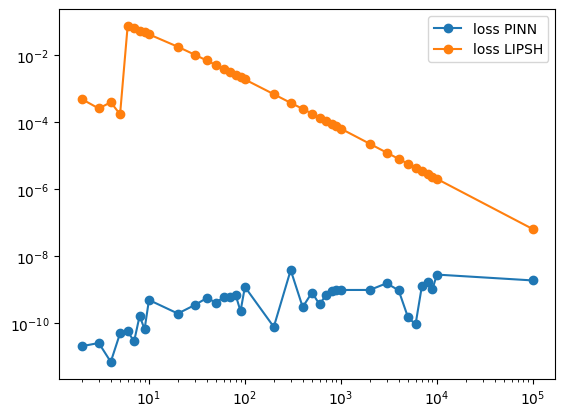

In [2]:
from ast import literal_eval

df_pinn = pd.read_csv('error_estimation_PINN_1.csv')
y = []
for i in df_pinn['l2_loss']:
    y.append(literal_eval(i)[0])
# plt.plot(df['grid_res'], df_pinn['l2_norm']**2, '-*', label='l2_norm: PINN')
plt.plot(df_pinn['grid_res'], y, '-o', label='loss PINN')
plt.yscale('log')
plt.xscale('log')
plt.legend()

df_lip = pd.read_csv('error_estimation_PINN_LIPSH.csv')
y = []
for i in df_lip['l2_loss']:
    y.append(literal_eval(i)[0])
# plt.plot(df['grid_res'], df_lip['l2_norm']**2, '-*', label='l2_norm: LIPSH')
plt.plot(df_lip['grid_res'], y, '-o', label='loss LIPSH')
plt.yscale('log')
plt.xscale('log')
plt.legend()


Уравнение Пуассона с аналитическим решением u=tanh(x)

array([0.75131836])

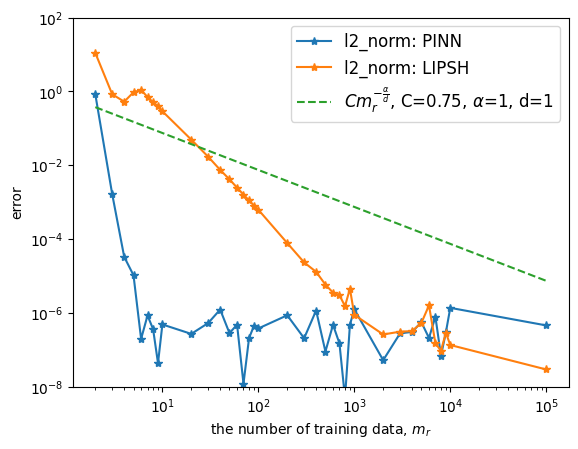

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import least_squares

def func(x, a):
    return a / (x)


ydata_pinn = df_pinn['l2_norm']
ydata_lip = df_lip['l2_norm']

plt.plot(df_pinn['grid_res'], ydata_pinn**2, '-*', label='l2_norm: PINN')
plt.plot(df_lip['grid_res'], ydata_lip**2, '-*', label='l2_norm: LIPSH')
plt.xlabel('the number of training data, $m_r$')
plt.ylabel('error')
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-8, 100)
# plt.xlim(0, 1e4)

popt, pcov = curve_fit(func, df_pinn['grid_res'], ydata_pinn**2)
# def minim(a):
#     return func(xdata, a) - ydata
# result = least_squares(minim, 1)

plt.plot(df_pinn['grid_res'], func(df_pinn['grid_res'], *popt), '--', label=r"$C m_r^{-\frac{\alpha}{d}}$, C=0.75, $\alpha$=1, d=1")
plt.legend(fontsize="12")

## альфа - константа гёльедра.
## d - размерность входного пространства (R^d)
## C - подобранная константа методом curve_fit
popt

график из статьи https://arxiv.org/pdf/2004.01806.pdf

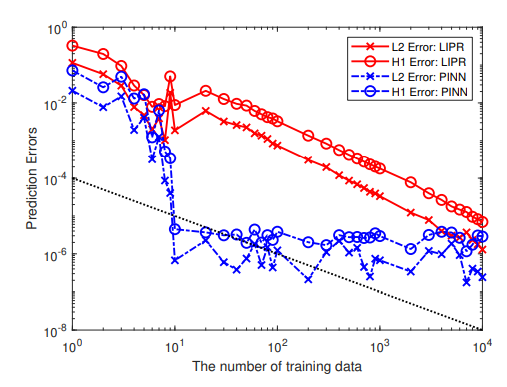

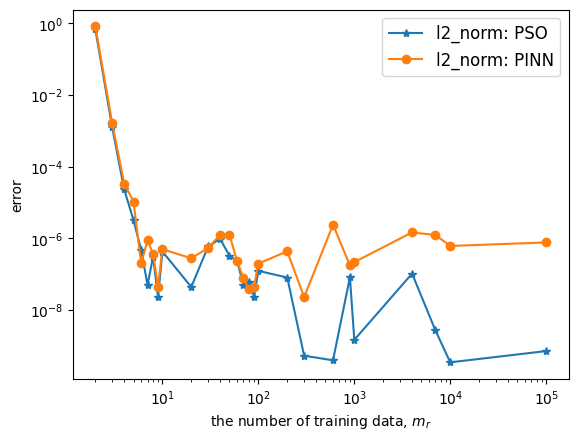

In [4]:
df_pso = pd.read_csv('error_estimation_PINN_PSO.csv')

ydata_pso = df_pso['l2_PSO']
ydata_pinn = df_pso['l2_pinn']

plt.plot(df_pso['grid_res'], ydata_pso**2, '-*', label='l2_norm: PSO')
plt.plot(df_pso['grid_res'], ydata_pinn**2, '-o', label='l2_norm: PINN')

plt.xlabel('the number of training data, $m_r$')
plt.ylabel('error')
plt.yscale('log')
plt.xscale('log')
plt.legend(fontsize="12")
# plt.ylim(1e-8, 100)

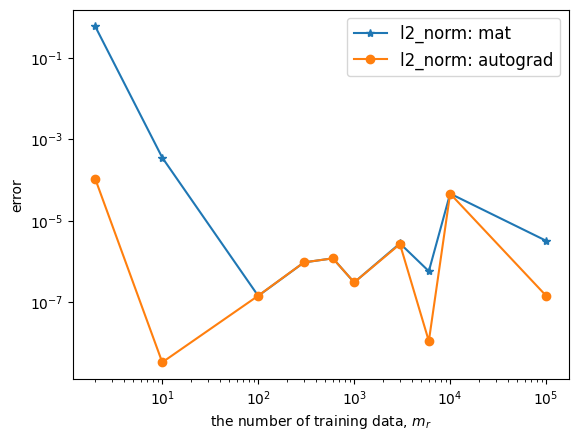

In [5]:
df_pso = pd.read_csv('error_estimation_mat.csv')

ydata_pso = df_pso['l2_mat']
ydata_pinn = df_pso['l2_pinn']

plt.plot(df_pso['grid_res'], ydata_pso**2, '-*', label='l2_norm: mat')
plt.plot(df_pso['grid_res'], ydata_pinn**2, '-o', label='l2_norm: autograd')

plt.xlabel('the number of training data, $m_r$')
plt.ylabel('error')
plt.yscale('log')
plt.xscale('log')
plt.legend(fontsize="12")
# plt.ylim(1e-8, 100)

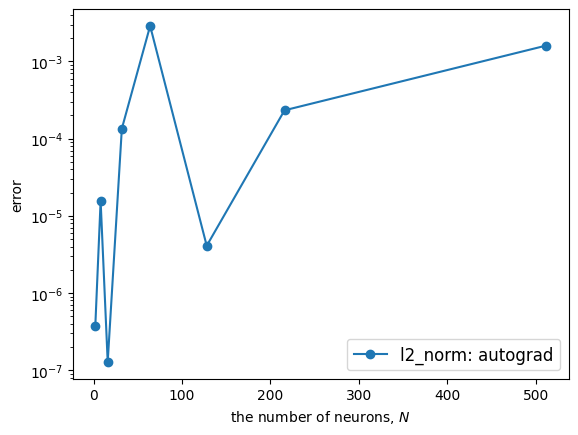

In [6]:
from ast import literal_eval
df = pd.read_csv('error_estimation_PINN_neurons.csv')

# ydata_pso = df_pso['l2_mat']
ydata_pinn = df['l2_norm']

# plt.plot(df_pso['grid_res'], ydata_pso**2, '-*', label='l2_norm: mat')
plt.plot(df['NN_res'], ydata_pinn**2, '-o', label='l2_norm: autograd')

plt.xlabel('the number of neurons, $N$')
plt.ylabel('error')
plt.yscale('log')
# plt.xscale('log')
plt.legend(fontsize="12")

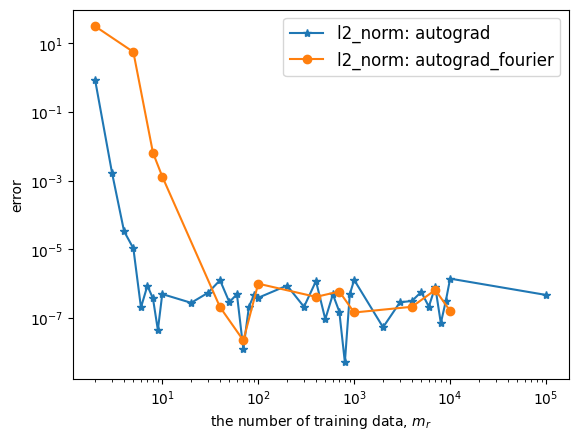

In [7]:
df = pd.read_csv('error_estimation_PINN_fourier.csv')
ydata_fourier = df['l2_norm']

df_pinn = pd.read_csv('error_estimation_PINN_1.csv')

plt.plot(df_pinn['grid_res'], df_pinn['l2_norm']**2, '-*', label='l2_norm: autograd')
plt.plot(df['grid_res'], ydata_fourier**2, '-o', label='l2_norm: autograd_fourier')
plt.xlabel('the number of training data, $m_r$')
plt.ylabel('error')
plt.yscale('log')
plt.xscale('log')
plt.legend(fontsize="12")


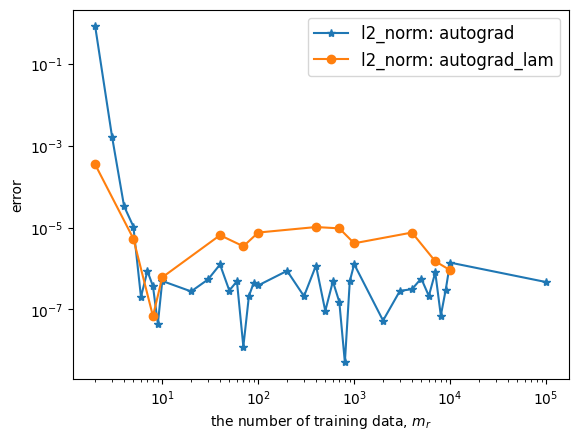

In [10]:
df = pd.read_csv('error_estimation_PINN_lam.csv')
ydata_lam = df['l2_norm']

df_pinn = pd.read_csv('error_estimation_PINN_1.csv')

plt.plot(df_pinn['grid_res'], df_pinn['l2_norm']**2, '-*', label='l2_norm: autograd')
plt.plot(df['grid_res'], ydata_lam**2, '-o', label='l2_norm: autograd_lam')
plt.xlabel('the number of training data, $m_r$')
plt.ylabel('error')
plt.yscale('log')
plt.xscale('log')
plt.legend(fontsize="12")

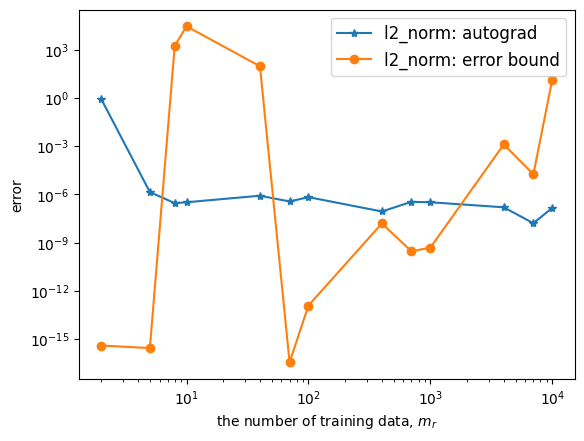

In [11]:
df = pd.read_csv('error_estimation_PINN_error_bound.csv')
ydata = df['l2_norm']
error_bound = df['error_bound']

plt.plot(df['grid_res'], ydata**2, '-*', label='l2_norm: autograd')
plt.plot(df['grid_res'], error_bound**2, '-o', label='l2_norm: error bound')
plt.xlabel('the number of training data, $m_r$')
plt.ylabel('error')
plt.yscale('log')
plt.xscale('log')
plt.legend(fontsize="12")